# Subspace partitioning

This notebook applies PRIM to the model in order to find the most important parameters for the model and their ranges.

In [1]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)

%matplotlib inline
from ipywidgets import interact

from ema_workbench import (Model,MultiprocessingEvaluator, SequentialEvaluator, Policy,
                           Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

C:\Program Files\Python\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Program Files\Python\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Program Files\Python\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Getting scenarios
If *run_Scenario* is True, then experiments are run (*n_Scenarios* number of times) by Multiprocessing.
Otherwise the result of a previous run is loaded.

In [2]:
run_Scenarios=False
n_Scenarios = 1000

ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(1)

if __name__ == '__main__':
    # Creating a "Don't do anything" policy
    # no dike increase, no warning, none of the rfr
    zero_policy = {'DaysToThreat': 0}
    zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
    zero_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})
    pol0 = {}

    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy('Policy 0', **pol0)
    
    #In case it was asked for, run the experiments
    if run_Scenarios:
        #Prints start time for performance measurements
        print('Startet evaluating at:',datetime.now())
        
        with MultiprocessingEvaluator(dike_model) as evaluator:
            results = evaluator.perform_experiments(scenarios=n_Scenarios, policies=policy0)
        
        #Of course, a stopping time is also needed
        print('Stopped evaluating at:',datetime.now())
        
        #experiments and outcomes are stored in an csv file
        experiments, outcomes = results
        outcomes = pd.DataFrame(outcomes)
        
        experiments.to_csv('./results/exp_unc_p0_{}s.csv'.format(n_Scenarios))
        outcomes.to_csv('./results/out_unc_p0_{}s.csv'.format(n_Scenarios))

    else:
        #IN case it was asked for, load the experiments and outcomes from the csv file
        experiments = pd.read_csv('./results/exp_unc_p0_{}s.csv'.format(n_Scenarios),index_col=0)
        outcomes = pd.read_csv('./results/out_unc_p0_{}s.csv'.format(n_Scenarios),index_col=0)

## PRIM

First, the outcomes need to be classified this can be adjusted in the next line. Also only the uncertainties are taken from the experiments dataframe to be analyzed by PRIM.

Further down the histogram of the outcomes are shown to get a better sense for the classification.

In [7]:
#Turning outcomes into binary True or False
classification = outcomes['Expected Number of Deaths'] < 1

#Only selecting the uncertainties for further processing
exp1 = experiments.loc[:,list(dike_model.uncertainties.keys())]

In [4]:
def plot(col):
    plt.hist(outcomes[col],bins=50)
    plt.xlabel(col)
    plt.tight_layout()
    
interact(plot,col=outcomes.columns)

interactive(children=(Dropdown(description='col', options=('Expected Annual Damage', 'Total Investment Costs',…

<function __main__.plot(col)>

In [12]:
box1.inspect(1)

coverage           1
density     0.323158
id                 1
mass            0.95
mean        0.323158
res_dim            1
Name: 1, dtype: object

              box 1                                     
                min     max                    qp values
A.1_pfail  0.049821  0.9996  [0.14820051008527482, -1.0]



[MainProcess/INFO] 1000 points remaining, containing 307 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.157, coverage: 0.511400651465798, density: 1.0 restricted_dimensions: 6


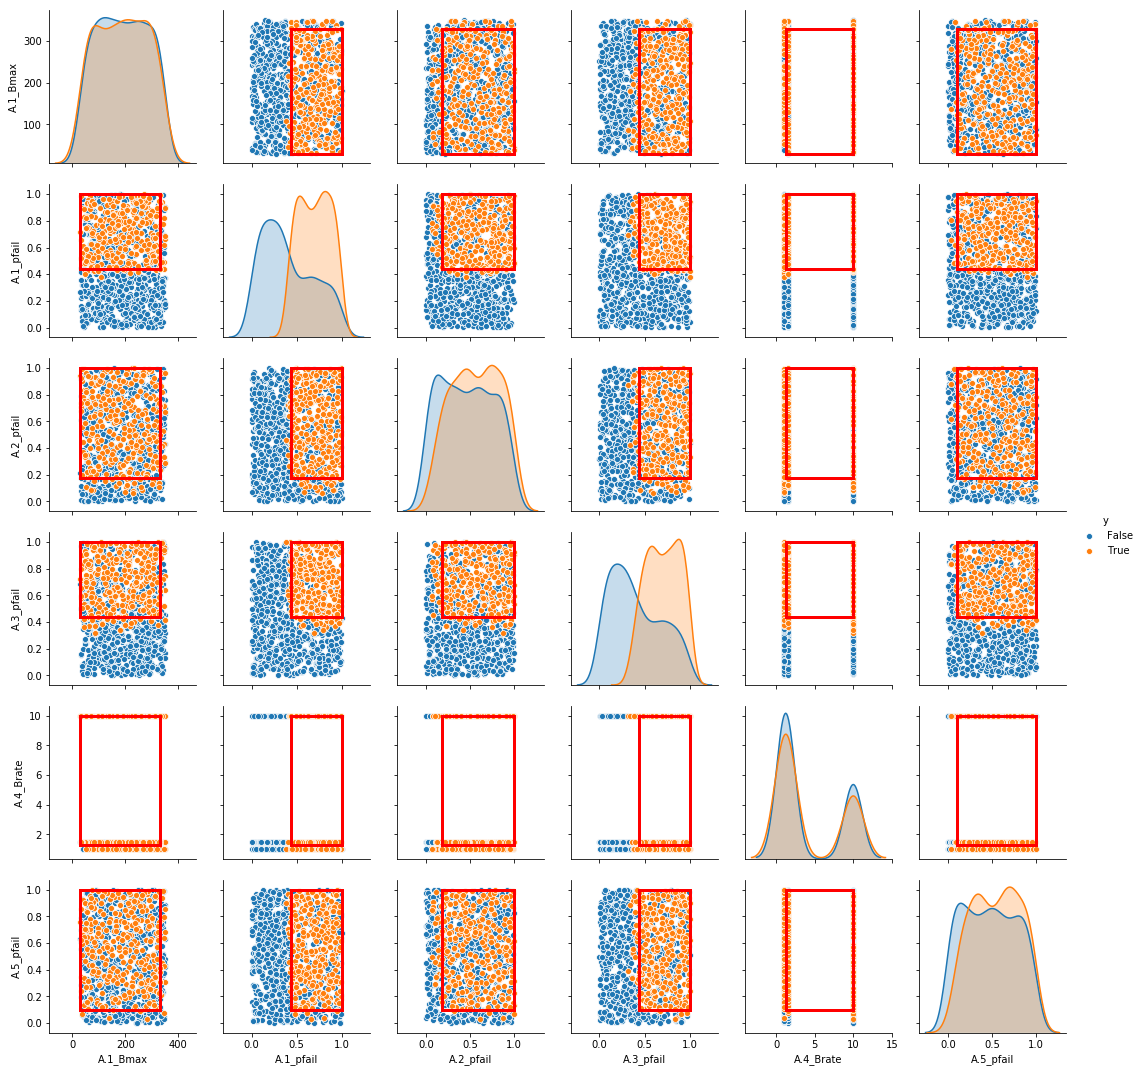

In [8]:
#Performing PRIM. Parameters can be set here.
prim_alg = prim.Prim(exp1.astype(float),classification,threshold=0.8, peel_alpha=0.05)
box1 = prim_alg.find_box()

#Plotting and saving
fig = box1.show_pairs_scatter()
plt.show()
fig.savefig('./results/prim_unc_{}s.png'.format(n_Scenarios),dpi=300)

### Trade off plot

In [10]:
?prim.Prim

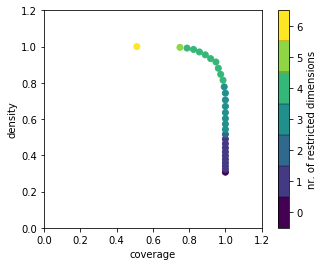

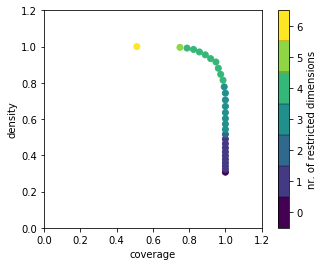

In [11]:
box1.show_tradeoff()

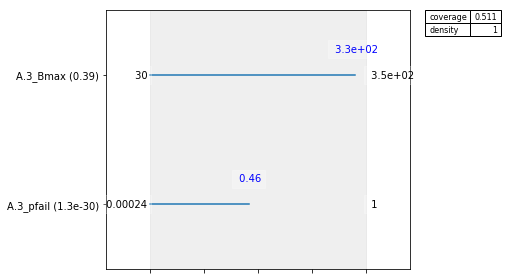

In [64]:
box1.inspect(style='graph')
plt.tight_layout()